In [1]:
%run ~/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

In [2]:
infiles = glob.glob('./s7-chea.dir/*')[:-1]
infiles

['./s7-chea.dir/AHF2617-control_vs_RL-chea.txt',
 './s7-chea.dir/A375_melanoma-control_vs_RL-chea.txt',
 './s7-chea.dir/Keloid_MW3-control_vs_RL-chea.txt',
 './s7-chea.dir/AG13145-control_vs_RL-chea.txt',
 './s7-chea.dir/AHF2796-control_vs_RL-chea.txt',
 './s7-chea.dir/AHF2697-control_vs_RL-chea.txt']

In [3]:
results = []
for infile in infiles:
    enrichment_dataframe = pd.read_table(infile)
    cell_line = os.path.basename(infile).split('-')[0]
    enrichment_dataframe['cell_line'] = cell_line
    terms = []
    results.append(enrichment_dataframe)
result_dataframe = pd.concat(results)
enrichment_dataframes = {x: result_dataframe[result_dataframe['direction'] == x] for x in ['up', 'down']}
enrichment_dataframes['down'].head()

Rank  Score      TF direction cell_line
1632     1   8.67  SETBP1      down   AHF2617
1633     2  19.00  TWIST2      down   AHF2617
1634     3  25.00    GLI3      down   AHF2617
1635     4  41.00    EBF2      down   AHF2617
1636     5  42.70   ATOH8      down   AHF2617

In [4]:
for key, value in enrichment_dataframes.items():
    pivot_dataframe = value.pivot(index='TF', columns='cell_line', values='Score')
    tfs = pivot_dataframe.mean(axis=1).sort_values().index[:20]
    heatmap_dataframe = pivot_dataframe.loc[tfs]
    display(HTML(heatmap_dataframe.to_html()))

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



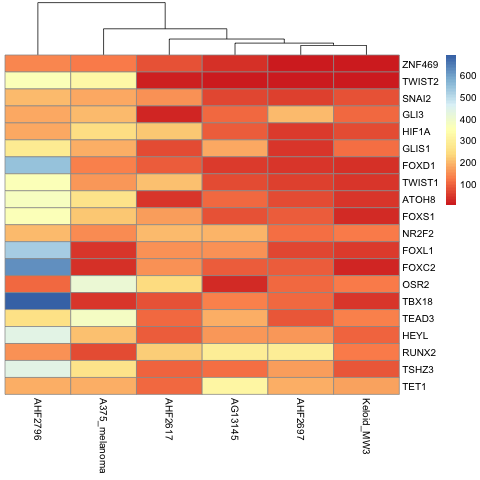

In [5]:
%%R -i heatmap_dataframe
pheatmap::pheatmap(heatmap_dataframe,
   color = rev(colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(100)),
    cluster_rows=FALSE,
   display_numbers=FALSE)

In [6]:
%%R
stacked_barplot <- function(stacked_plot_dataframe, terms, direction) {
    
stacked_plot_dataframe$TF <- factor(stacked_plot_dataframe$TF, levels=rev(terms))
gp <- ggplot(stacked_plot_dataframe, aes(x=TF, y=Score, fill=cell_line)) +
    geom_bar(stat='identity') +
    #facet_wrap(~, scales='free') +
    coord_flip() +
    #scale_fill_manual(values=c('', '')) +
    #scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_x_log10() +
    #scale_y_log10() +
    #scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #ggtitle('') +
    #geom_abline(intercept=0, slope=1) +
    #xlab('') +
    #ylab('') +
    labs(title = paste0('Top Predicted TFs - ', direction, 'regulated genes'), y = 'Average Rank', x = '', color = '', fill='Cell line') +
    #guides(fill=FALSE) +
    theme_classic() +
    theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))
print(gp)
}


/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



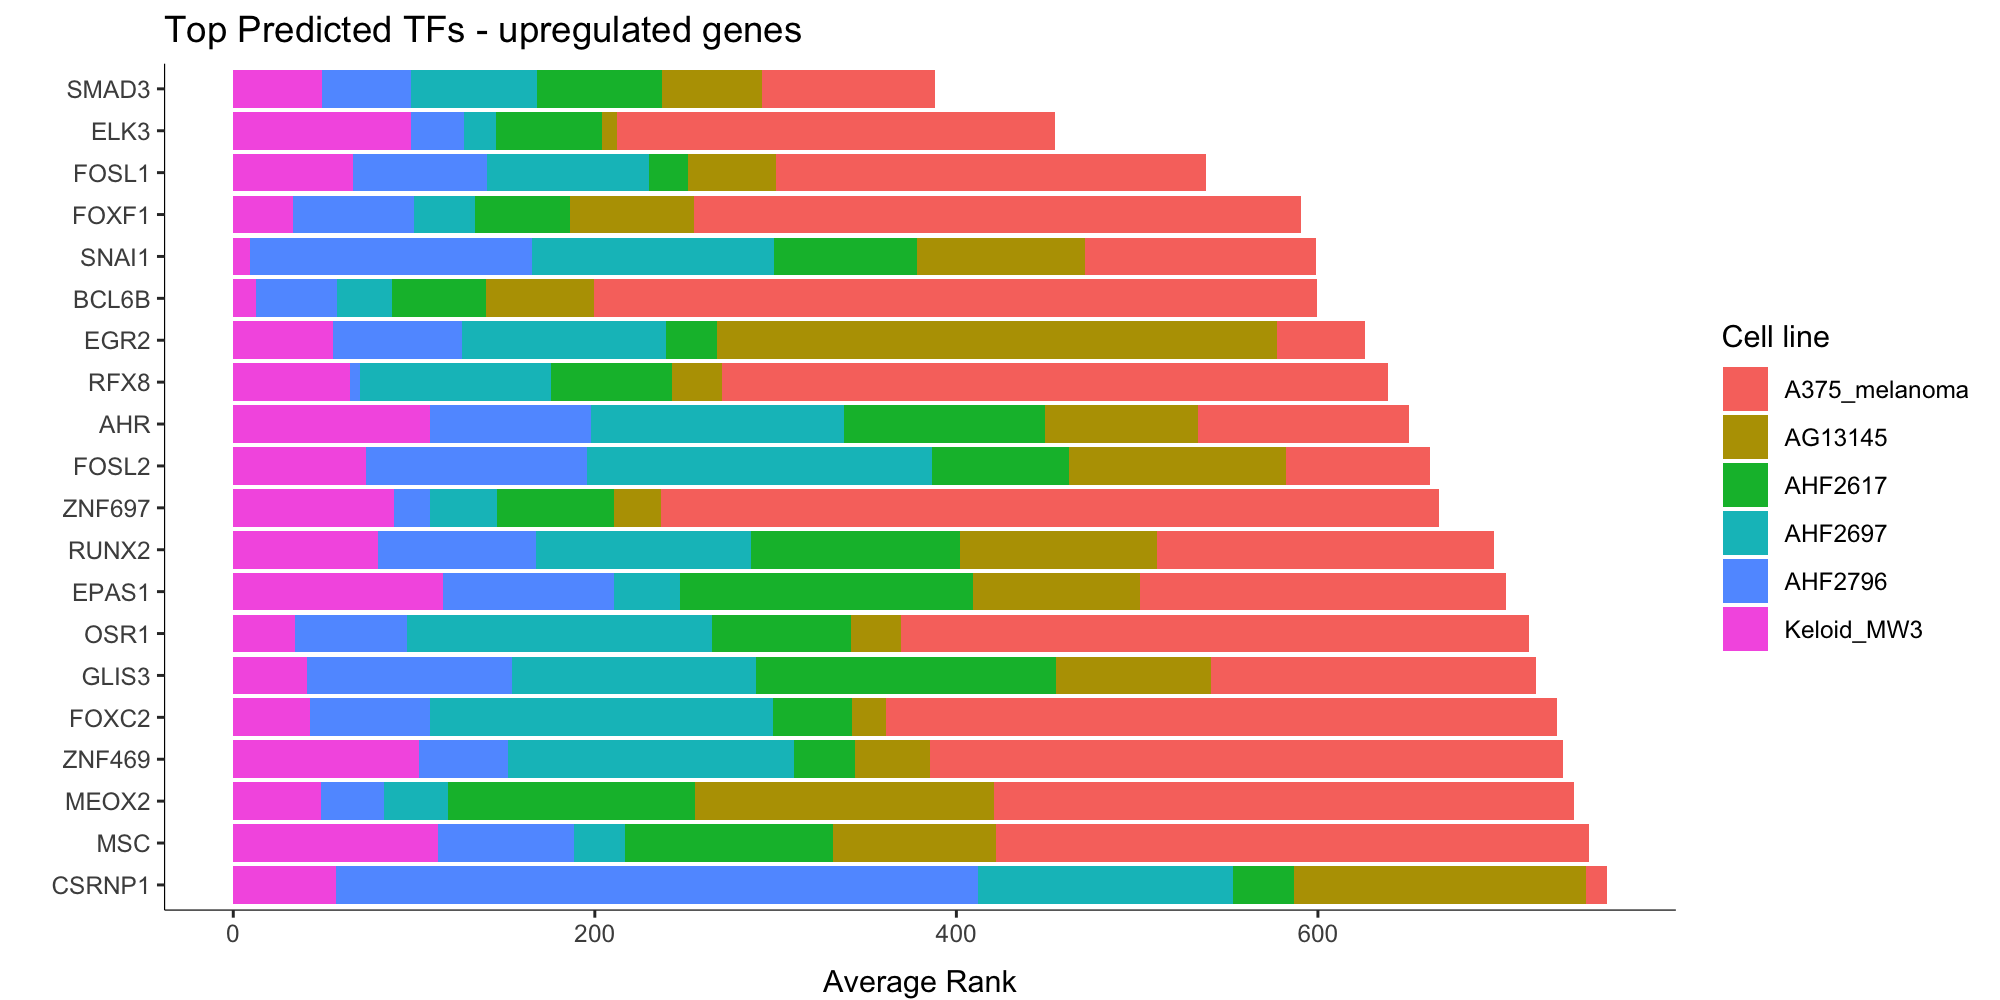

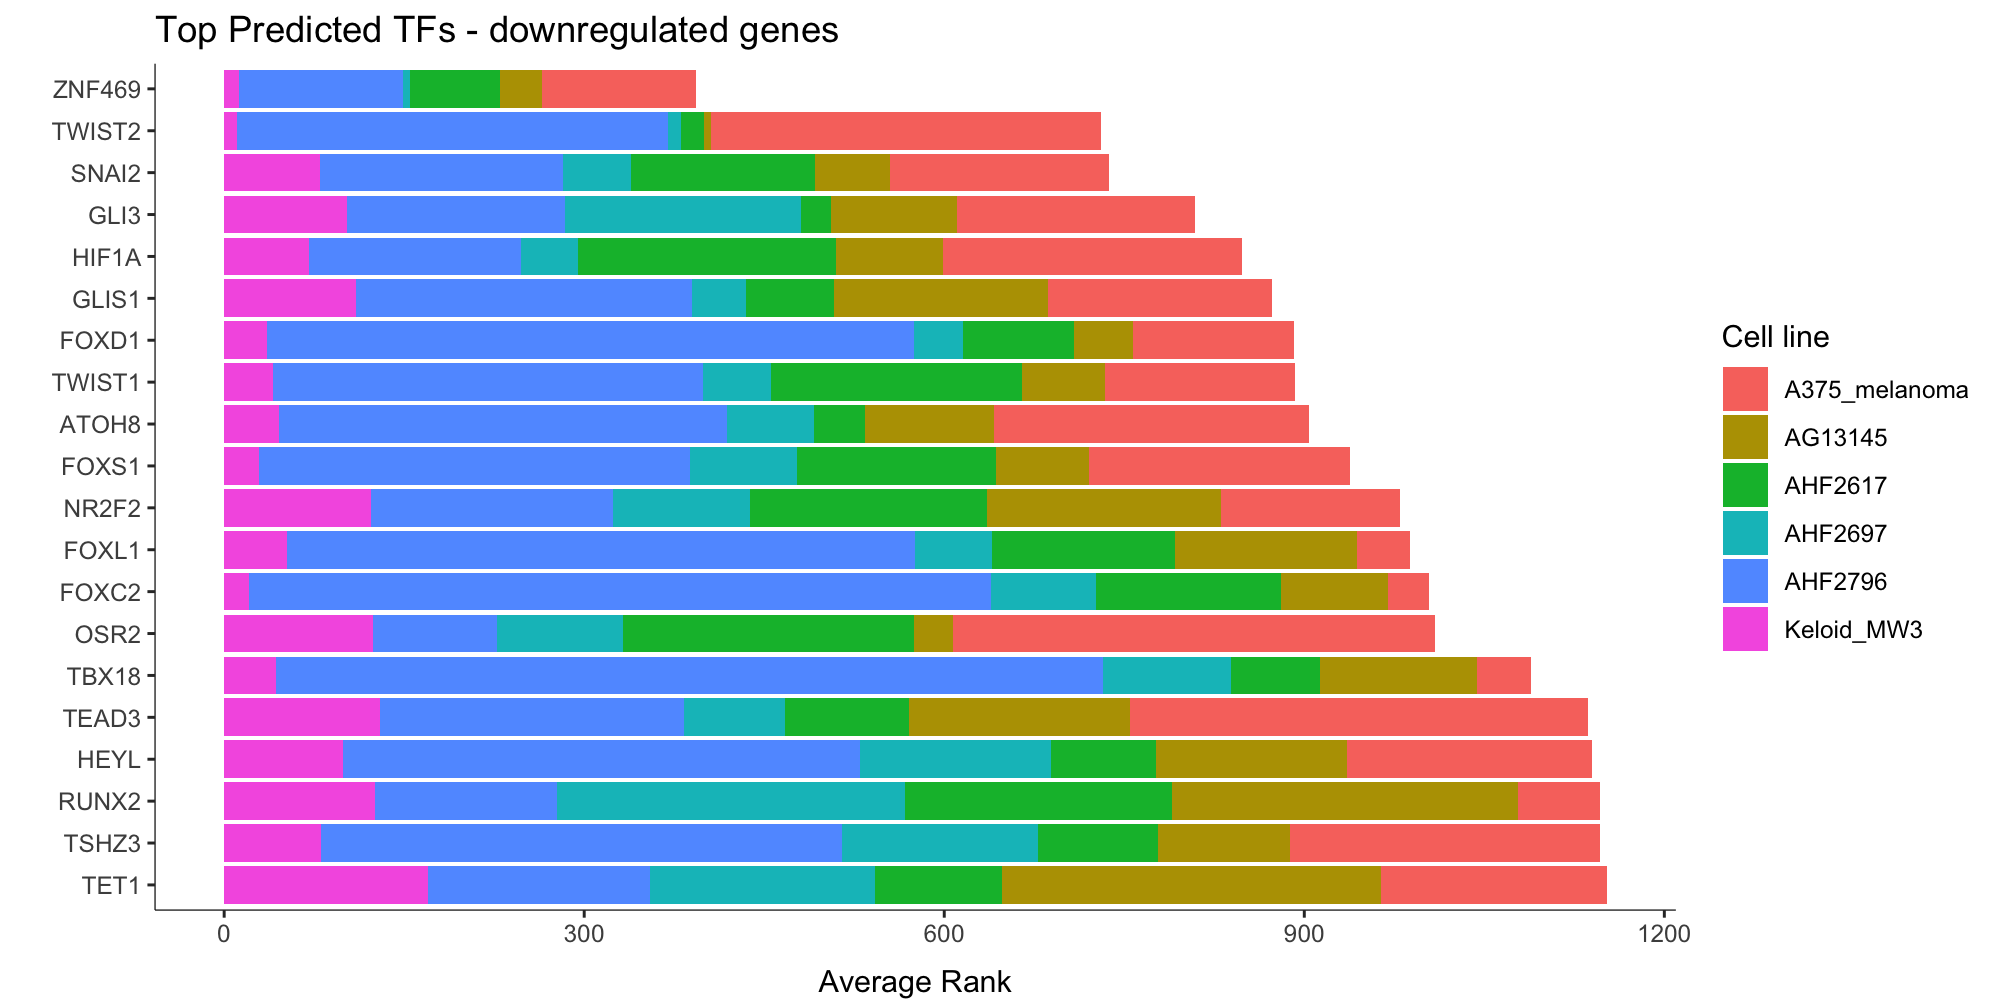

In [7]:
for direction, enrichment_dataframe_subset_subset in enrichment_dataframes.items():
    pivot_dataframe = enrichment_dataframe_subset_subset.pivot(index='TF', columns='cell_line', values='Score')
    terms = pivot_dataframe.sum(axis=1).sort_values().index[:20]
    stacked_plot_dataframe = enrichment_dataframe_subset_subset.set_index('TF', drop=False).loc[terms]
    %R -i stacked_plot_dataframe,terms,direction -h 1000 -w 2000 -r 200 stacked_barplot(stacked_plot_dataframe, terms, direction) 

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



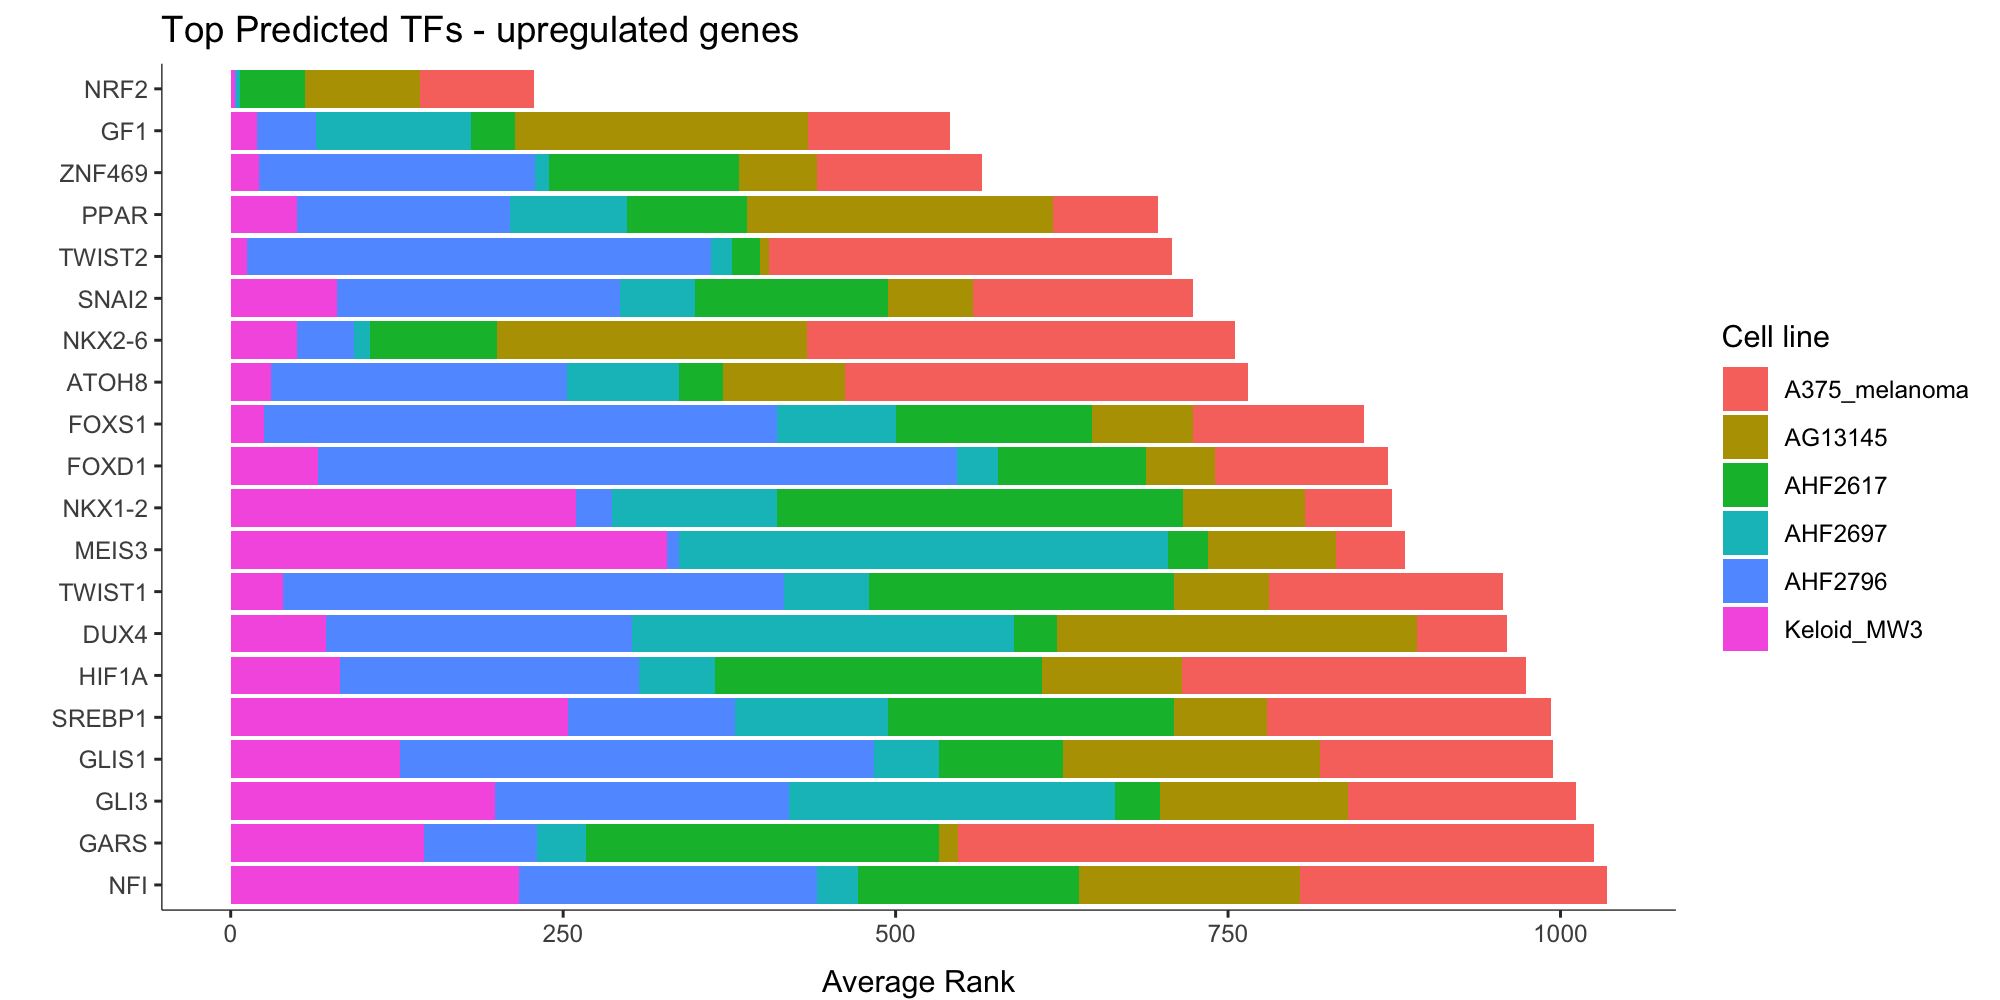

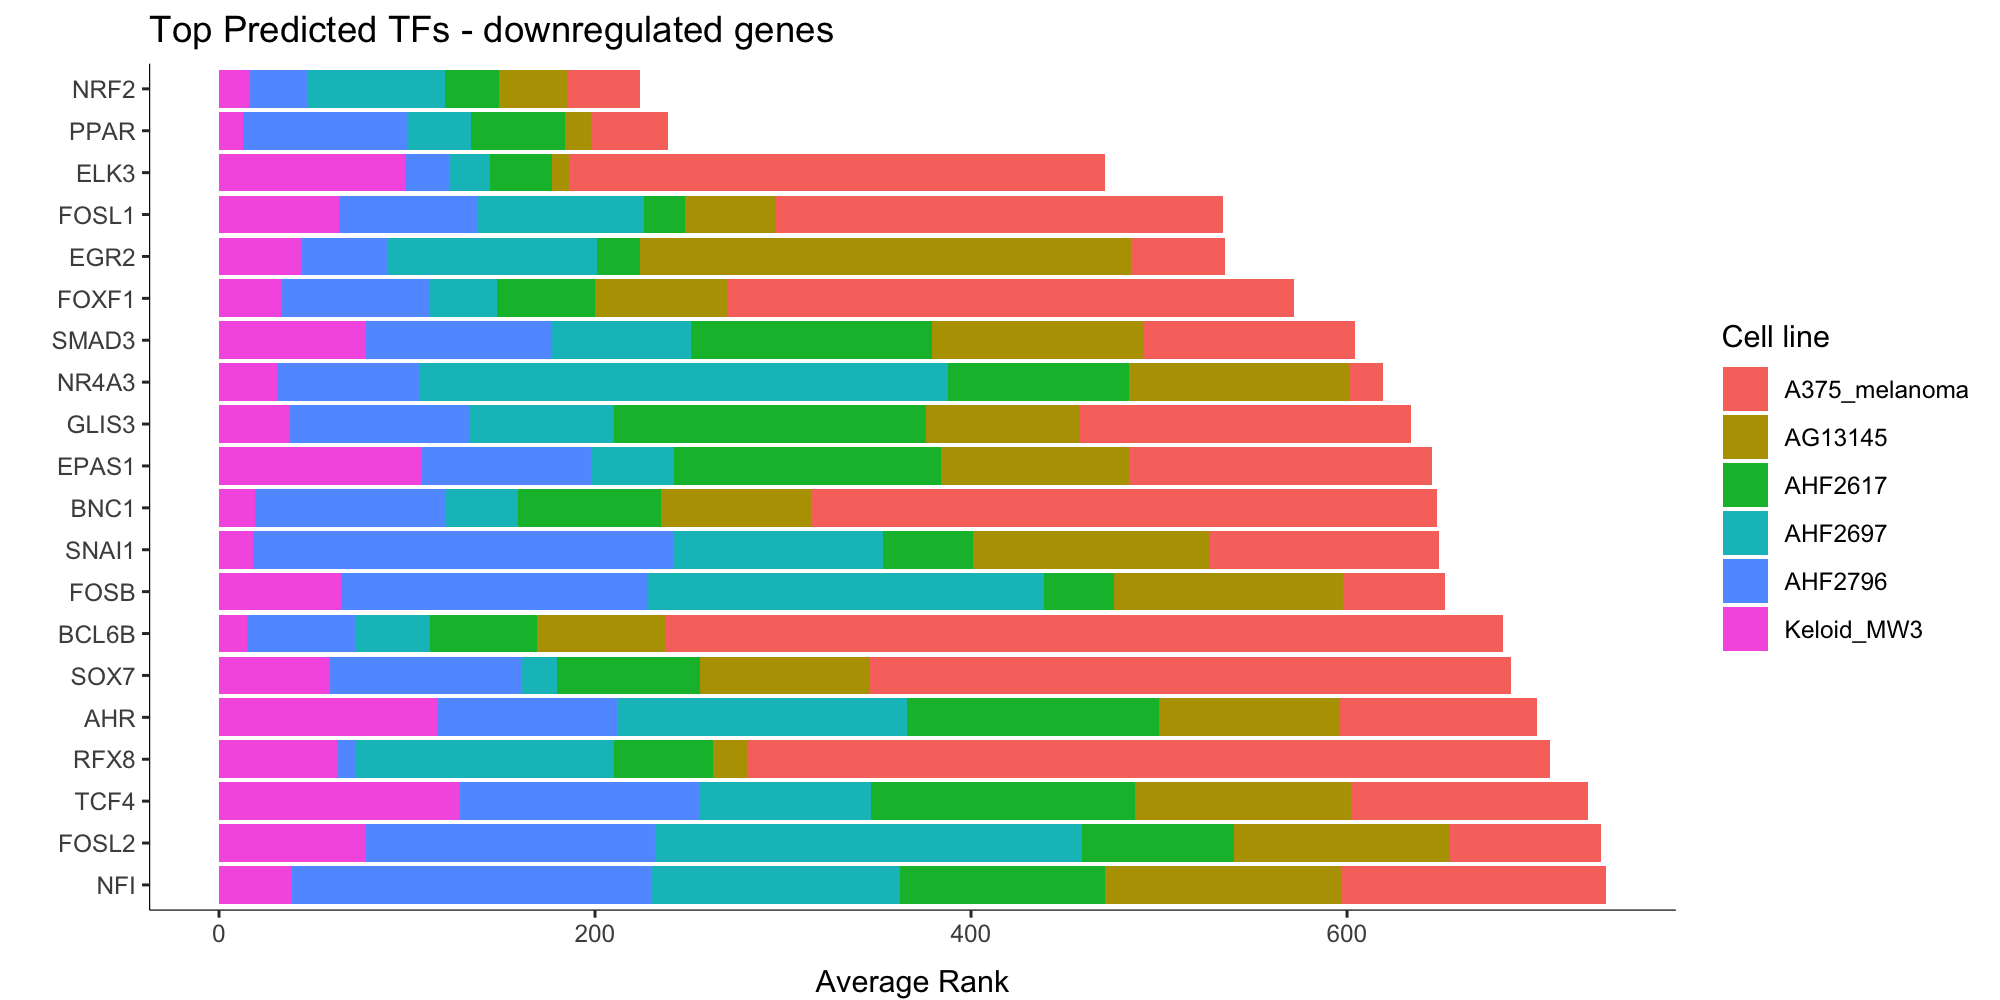

In [83]:
old = pd.read_table('./s7-chea.dir2/A375_melanoma-control_vs_RL-chea.txt').query('direction == "up"')
old.head()

Rank  Score      TF direction
0     1   31.0    RFX8        up
1     2   36.0   FOXC2        up
2     3   38.0   FOXL1        up
3     4   48.0  ZNF300        up
4     5   52.0  ZNF730        up

In [84]:
new = pd.read_table('./s7-chea.dir/A375_melanoma-control_vs_RL-chea.txt').query('direction == "up"')
new.head()

Rank  Score      TF direction
0     1   34.3   FOXC2        up
1     2   38.5  ZFP69B        up
2     3   42.0  ZNF300        up
3     4   43.7   FOXL1        up
4     5   44.3   TBX18        up

In [85]:
merged = old.merge(new, on='TF', suffixes=('_old', '_new'))
merged.head()

Rank_old  Score_old      TF direction_old  Rank_new  Score_new  \
0         1       31.0    RFX8            up         7       53.0   
1         2       36.0   FOXC2            up         1       34.3   
2         3       38.0   FOXL1            up         4       43.7   
3         4       48.0  ZNF300            up         3       42.0   
4         5       52.0  ZNF730            up        10       81.0   

  direction_new  
0            up  
1            up  
2            up  
3            up  
4            up

In [87]:
merged['diff'] = [rowData['Score_old']-rowData['Score_new'] for index, rowData in merged.iterrows()]

In [89]:
merged.sort_values('diff')

Rank_old  Score_old       TF direction_old  Rank_new  Score_new  \
32          38      129.0     BRF2            up      1360     1080.0   
10          13       68.0     DUX4            up       718      636.0   
348        369      425.0   BHLHA9            up      1216      954.0   
90         102      237.0   ZNF230            up       889      743.0   
797        830      686.0    ZNF20            up      1455     1180.0   
13          16       72.0     BNC1            up       598      564.0   
92         104      238.0     HES1            up       768      670.0   
164        180      314.0    KDM2B            up       873      731.0   
940        975      768.0    NKX25            up      1435     1170.0   
635        666      591.0    CREB3            up      1245      985.0   
1043      1079      831.0    ZBED9            up      1464     1190.0   
667        698      610.0   ZNF727            up      1223      964.0   
5            6       52.0    MEIS3            up       295      405.0   
1283      1326     1010.0    ZNF81            up      1570     1350.0   
1084      1122      858.0     MAFA            up      1465     1190.0   
763        795      665.0   ZNF474            up      1268      997.0   
1203      1245      949.0    NKX11            up      1533     1280.0   
912        947      749.0    NKX22            up      1359     1080.0   
213        231      342.0   ZNF566            up       766      670.0   
416        440      463.0     PBX2            up       955      781.0   
1418      1467     1140.0     MYCL            up      1615     1450.0   
372        395      437.0   ZNF461            up       894      745.0   
866        899      722.0   ZNF343            up      1294     1020.0   
842        875      713.0    SOX14            up      1277     1010.0   
1126      1165      883.0      DBP            up      1437     1170.0   
356        378      429.0   ZNF525            up       842      714.0   
183        200      325.0   ZNF426            up       658      598.0   
1214      1256      959.0    CXXC1            up      1502     1230.0   
264        283      375.0   ZNF530            up       727      639.0   
463        488      488.0    ZFP57            up       895      746.0   
...        ...        ...      ...           ...       ...        ...   
791        824      682.0    HOXA2            up       362      445.0   
782        815      676.0   ZBTB24            up       347      438.0   
1514      1566     1270.0    GTF2I            up      1309     1030.0   
984       1019      791.0    ZBTB2            up       565      546.0   
1229      1271      969.0   KCNIP3            up       858      724.0   
1269      1312     1000.0   ZNF160            up       904      751.0   
1192      1234      938.0   TRAFD1            up       801      688.0   
1004      1040      800.0      HLF            up       541      537.0   
1340      1384     1060.0    NKX62            up       984      797.0   
1022      1058      809.0  ZNF512B            up       557      543.0   
1096      1134      867.0   ZNF699            up       653      595.0   
1048      1086      835.0     DPF1            up       594      563.0   
1223      1265      965.0    SNAI3            up       797      686.0   
1617      1680     1570.0    CBLL2            up      1532     1280.0   
472        498      495.0    SNAI1            up        56      190.0   
1065      1103      844.0   PKNOX2            up       510      524.0   
627        658      587.0   ZNF227            up       108      267.0   
1461      1513     1200.0  FOXD4L6            up      1118      879.0   
826        859      708.0   ZNF229            up       250      377.0   
1504      1556     1260.0     MYT1            up      1189      924.0   
1505      1557     1260.0    ZBED6            up      1172      911.0   
1388      1436     1110.0    NR5A1            up       856      723.0   
1370      1417     1090.0      RAX            up       767      

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



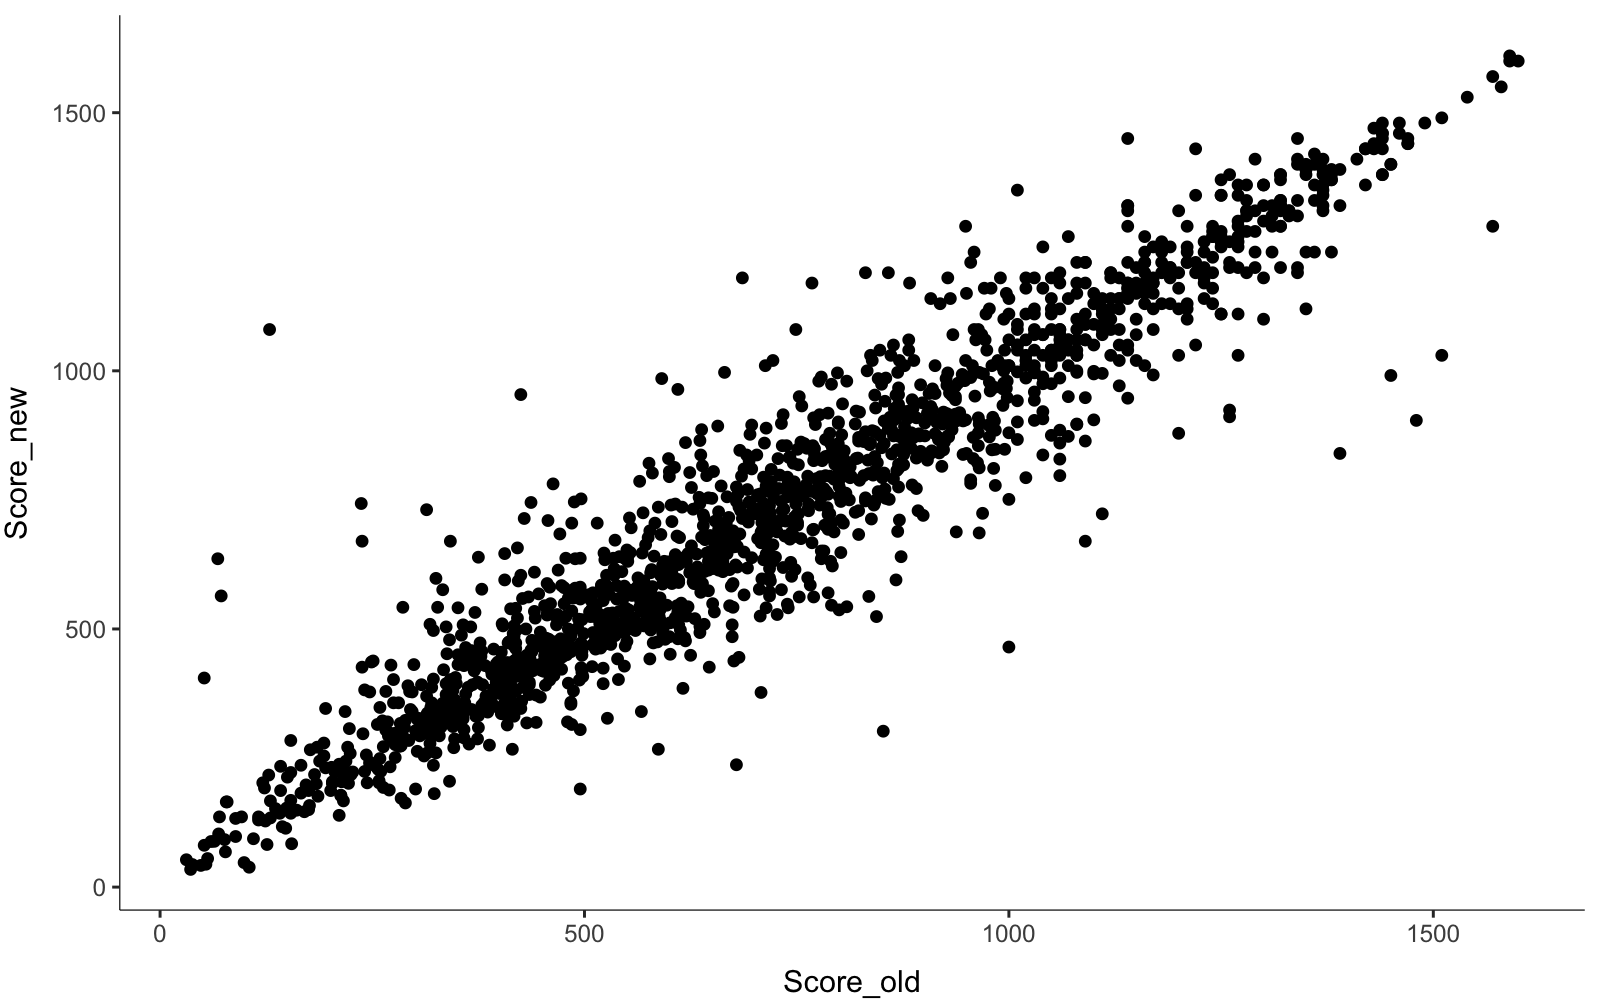

In [86]:
%%R -i merged -h 1000 -w 1600 -r 200
#ticks <- seq()
ggplot(merged, aes(x=Score_old, y=Score_new)) +
geom_point() +
#facet_wrap(~, scales='free') +
#coord_flip() +
#scale_fill_manual(values=c('', '')) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
#geom_abline(intercept=0, slope=1) +
#xlab('') +
#ylab('') +
#labs(title = '', x = '', y = '', color = '', fill='') +
#guides(fill=FALSE) +
theme_classic() +
theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))